<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/modeling/modeling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# -------------------------------------------------------------
# 0. Imports & data load
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# ---- Load the engineered features ----
df = pd.read_csv("/content/diabetes_features_engineered.csv")

# Identify the target column and survey-weight column -----------
TARGET_COL = "Diabetes_Comorbidity_Score"

WEIGHT_COL = "_LLCPWT" if "_LLCPWT" in df.columns else None   # BRFSS survey weight

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

sample_weights = df[WEIGHT_COL] if WEIGHT_COL else None

In [8]:
# -------------------------------------------------------------
# 1. Audit: dtypes, missing, class balance
# -------------------------------------------------------------
print(df.dtypes.to_string())

missing = df.isna().mean().sort_values(ascending=False).round(3)
print("\nMissingness (top 15):")
print(missing.head(15))

print("\nTarget distribution:")
print(y.value_counts(normalize=True).sort_index().round(4))


Unnamed: 0                      int64
SEXVAR                        float64
GENHLTH                       float64
PHYSHLTH                      float64
POORHLTH                      float64
EXERANY2                      float64
FALL12MN                      float64
FALLINJ5                      float64
_URBSTAT                      float64
_IMPRACE                      float64
_AGE80                        float64
Diabetes_Comorbidity_Score    float64
Diabetic_Care_Score           float64
Disability_Score              float64
Proactive_Care_Score            int64
Access_to_Care_Score            int64
Alcohol_Abuse_Indicator       float64
Tobacco_Score                 float64
social_score                    int64
Marijuana_Score               float64
Cognitive_Score               float64
BMI_Value                     float64
BMI_Category                   object
Region                         object

Missingness (top 15):
FALLINJ5                   0.674
Alcohol_Abuse_Indicator    0.670

# Preprocessing pipeline with imputers (fixes PCA NaN error)

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split feature types
numeric_cols     = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)



# PCA/t-SNE visuals on preprocessed matrix

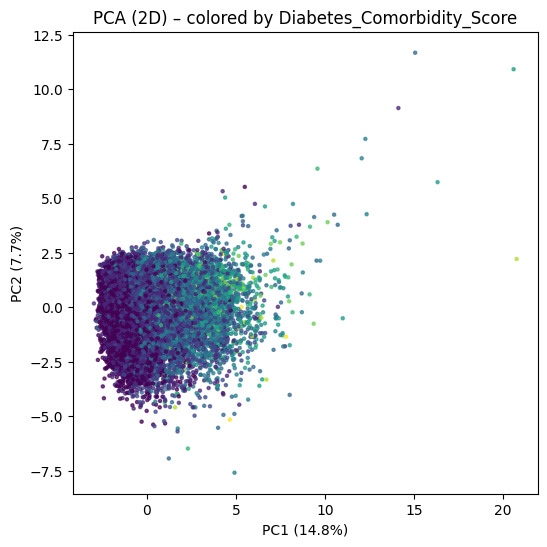

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


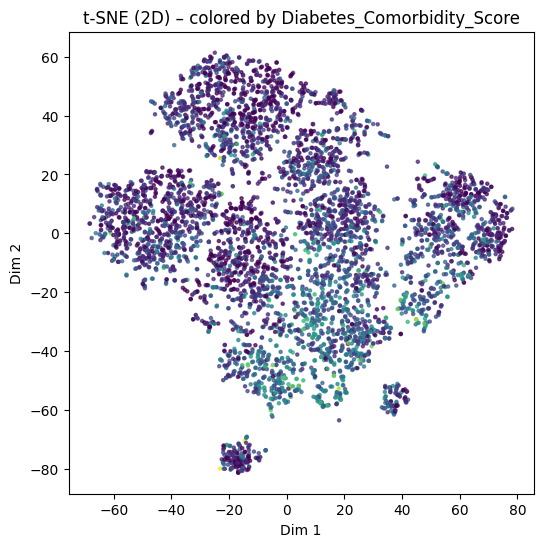

In [11]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Fit/transform once
X_proc = preprocess.fit_transform(X)

# Convert to dense for PCA if needed; PCA can take sparse but t-SNE wants dense
X_dense_for_tsne = X_proc.toarray() if hasattr(X_proc, "toarray") else np.asarray(X_proc)

# PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense_for_tsne)
plt.figure(figsize=(6,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=5, alpha=0.7)
plt.title("PCA (2D) – colored by Diabetes_Comorbidity_Score")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

# t-SNE (2D) – subsample for speed if needed
subset = np.random.RandomState(42).choice(X_dense_for_tsne.shape[0], size=min(5000, X_dense_for_tsne.shape[0]), replace=False)
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_dense_for_tsne[subset])
plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y.iloc[subset], s=5, alpha=0.7)
plt.title("t-SNE (2D) – colored by Diabetes_Comorbidity_Score")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()


 # Class imbalance check (multi-class)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
w_train = w_test = None
if WEIGHT_COL:
    w_train, w_test = df.loc[X_train.index, WEIGHT_COL], df.loc[X_test.index, WEIGHT_COL]


# Baseline Decision Tree (multi-class) with pipeline

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

tree_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=50,
        class_weight="balanced",   # basic imbalance handling
        random_state=42
    ))
])

fit_kwargs = {}
if w_train is not None:
    fit_kwargs["clf__sample_weight"] = w_train

tree_pipe.fit(X_train, y_train, **fit_kwargs)
y_pred = tree_pipe.predict(X_test)

print("\n--- Decision Tree metrics ---")
print("Accuracy:", accuracy_score(y_test, y_pred).round(3))
print("Balanced Acc:", balanced_accuracy_score(y_test, y_pred).round(3))
print(classification_report(y_test, y_pred, digits=3))



--- Decision Tree metrics ---
Accuracy: 0.243
Balanced Acc: 0.184
              precision    recall  f1-score   support

         0.0      0.413     0.584     0.484       940
         1.0      0.330     0.279     0.302      1187
         2.0      0.265     0.058     0.095       852
         3.0      0.192     0.009     0.018       529
         4.0      0.000     0.000     0.000       282
         5.0      0.059     0.139     0.083       137
         6.0      0.023     0.288     0.042        59
         7.0      0.009     0.050     0.015        20
         8.0      0.012     0.429     0.024         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.243      4014
   macro avg      0.130     0.184     0.106      4014
weighted avg      0.278     0.243     0.229      4014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest

--- Random Forest metrics ---
Accuracy:           0.335
Balanced Accuracy:  0.144
Macro AUC:          0.703

              precision    recall  f1-score   support

         0.0      0.462     0.466     0.464       940
         1.0      0.339     0.516     0.410      1187
         2.0      0.250     0.237     0.243       852
         3.0      0.217     0.134     0.166       529
         4.0      0.181     0.067     0.098       282
         5.0      0.111     0.015     0.026       137
         6.0      0.000     0.000     0.000        59
         7.0      0.000     0.000     0.000        20
         8.0      0.000     0.000     0.000         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.335      4014
   macro avg      0.156     0.144     0.141      4014
weighted avg      0.307     0.335     0.311      4014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


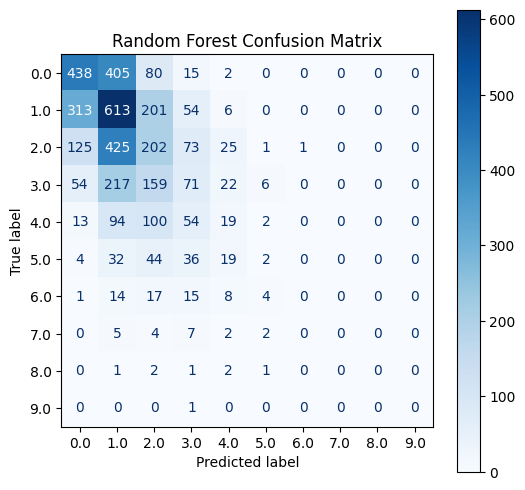

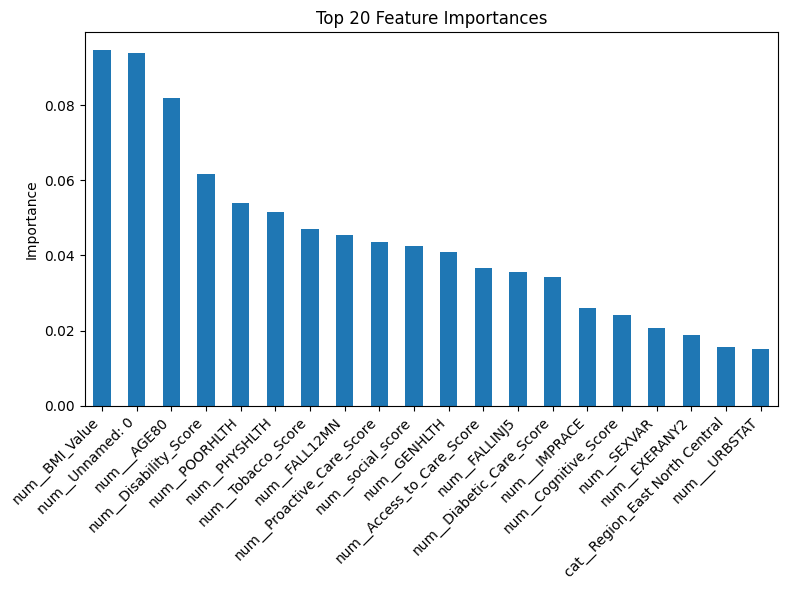

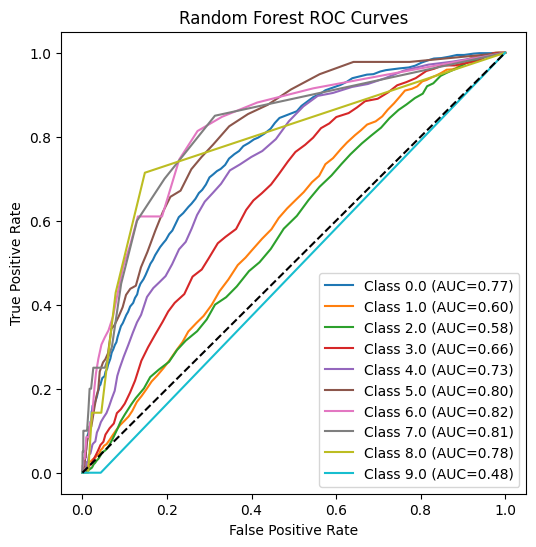

TypeError: CalibrationDisplay.__init__() got an unexpected keyword argument 'fraction_of_positives'

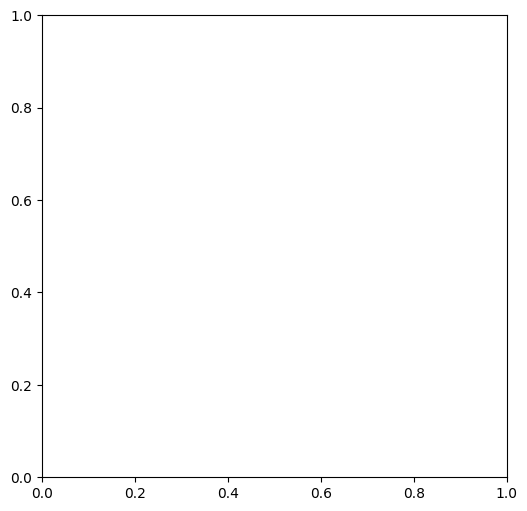

In [25]:
# Random Forest classification with evaluation plots
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Pipeline setup
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

# Fit model
rf_pipe.fit(X_train, y_train)

# Predict & probabilities
y_pred  = rf_pipe.predict(X_test)
y_proba = rf_pipe.predict_proba(X_test)

# Basic metrics
acc       = accuracy_score(y_test, y_pred)
bal_acc   = balanced_accuracy_score(y_test, y_pred)
y_test_bin = label_binarize(y_test, classes=np.sort(y.unique()))
macro_auc = roc_auc_score(y_test_bin, y_proba,
                          average="macro", multi_class="ovr")

print("--- Random Forest metrics ---")
print(f"Accuracy:           {acc:.3f}")
print(f"Balanced Accuracy:  {bal_acc:.3f}")
print(f"Macro AUC:          {macro_auc:.3f}")
print("\n" + classification_report(y_test, y_pred, digits=3))

# 1) Confusion Matrix
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=np.sort(y.unique()),
    cmap="Blues",
    ax=ax
)
ax.set_title("Random Forest Confusion Matrix")
plt.show()

# 2) Feature Importances (Top 20)
importances   = rf_pipe.named_steps["clf"].feature_importances_
feat_names    = rf_pipe.named_steps["prep"].get_feature_names_out()
feat_imp_ser  = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:20]
fig, ax = plt.subplots(figsize=(8,6))
feat_imp_ser.plot.bar(ax=ax)
ax.set_title("Top 20 Feature Importances")
ax.set_ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3) One-vs-Rest ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(np.sort(y.unique())):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(6,6))
for i, cls in enumerate(np.sort(y.unique())):
    ax.plot(fpr[i], tpr[i], label=f"Class {cls} (AUC={roc_auc[i]:.2f})")
ax.plot([0,1], [0,1], "k--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Random Forest ROC Curves")
ax.legend(loc="lower right")
plt.show()

# 4) Calibration Curve for Class 1 (example)
cls_idx = 1
prob_pos = y_proba[:, cls_idx]
true_bin = y_test_bin[:, cls_idx]
frac_pos, mean_pred = calibration_curve(true_bin, prob_pos, n_bins=10)
fig, ax = plt.subplots(figsize=(6,6))
CalibrationDisplay(
    fraction_of_positives=frac_pos,
    mean_predicted_value=mean_pred,
    estimator_name=f"Class {np.sort(y.unique())[cls_idx]}",
    ax=ax
)
ax.set_title(f"Calibration Curve - Class {np.sort(y.unique())[cls_idx]}")
plt.show()


# LightGBM

In [16]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

lgbm_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LGBMClassifier(
        n_estimators=600,
        learning_rate=0.03,
        objective="multiclass",
        num_class=y.nunique(),
        class_weight="balanced",
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Weighted multiclass AUC is fiddly; we’ll use macro-averaged AUC if proba available
def macro_auc(model, X_val, y_val):
    from sklearn.preprocessing import label_binarize
    y_proba = model.predict_proba(X_val)
    classes = np.sort(y.unique())
    y_true_binarized = label_binarize(y_val, classes=classes)
    return roc_auc_score(y_true_binarized, y_proba, average="macro", multi_class="ovr")

# Cross-validate with weights (fit_params)
fit_params = {}
if WEIGHT_COL:
    fit_params = {"clf__sample_weight": df[WEIGHT_COL]}

# Manual CV to compute macro AUC
scores = []
for tr_idx, va_idx in cv.split(X, y):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    fit_kwargs = {}
    if WEIGHT_COL:
        fit_kwargs["clf__sample_weight"] = df.iloc[tr_idx][WEIGHT_COL]
    lgbm_pipe.fit(X_tr, y_tr, **fit_kwargs)
    scores.append(macro_auc(lgbm_pipe, X_va, y_va))

print(f"\nLightGBM CV macro AUC: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Final fit + test metrics
fit_kwargs = {}
if w_train is not None:
    fit_kwargs["clf__sample_weight"] = w_train
lgbm_pipe.fit(X_train, y_train, **fit_kwargs)

y_pred = lgbm_pipe.predict(X_test)
y_proba = lgbm_pipe.predict_proba(X_test)
print("\n--- LightGBM test metrics ---")
print("Accuracy:", accuracy_score(y_test, y_pred).round(3))
print("Balanced Acc:", balanced_accuracy_score(y_test, y_pred).round(3))
try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_test, classes=np.sort(y.unique()))
    print("Macro AUC:", roc_auc_score(y_true_bin, y_proba, average="macro", multi_class="ovr").round(3))
except Exception as e:
    print("AUC not available:", e)
print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 16056, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM CV macro AUC: 0.727 ± 0.031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 16055, number of used features: 34
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM test metrics ---


AttributeError: 'float' object has no attribute 'round'

## LightGBM v2 - Speed-Optimized

In [19]:
# Ultra-fast LightGBM: 2-fold CV, 250 trees
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
import numpy as np

lgbm_ultra = LGBMClassifier(
    objective="multiclass",
    num_class=y.nunique(),
    n_estimators=250,
    learning_rate=0.1,
    num_leaves=15,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

pipe_ultra = Pipeline([("prep", preprocess), ("clf", lgbm_ultra)])
cv_ultra = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# CV
scores = []
for tr, va in cv_ultra.split(X, y):
    pipe_ultra.fit(X.iloc[tr], y.iloc[tr])
    y_p = pipe_ultra.predict_proba(X.iloc[va])
    y_tb = label_binarize(y.iloc[va], classes=np.sort(y.unique()))
    scores.append(roc_auc_score(y_tb, y_p, average="macro", multi_class="ovr"))

print(f"Ultra-fast CV macro AUC: {round(np.mean(scores),3)} ± {round(np.std(scores),3)}")

# Final fit + test
pipe_ultra.fit(X_train, y_train)
y_pr = pipe_ultra.predict(X_test)
y_pb = pipe_ultra.predict_proba(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pr),3))
print("Balanced Acc:", round(balanced_accuracy_score(y_test, y_pr),3))
print("Macro AUC:",
      round(roc_auc_score(label_binarize(y_test, classes=np.sort(y.unique())), y_pb,
                          average="macro", multi_class="ovr"),3))
print(classification_report(y_test, y_pr, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Ultra-fast CV macro AUC: 0.727 ± 0.002


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.301
Balanced Acc: 0.187
Macro AUC: 0.68
              precision    recall  f1-score   support

         0.0      0.442     0.598     0.508       940
         1.0      0.356     0.242     0.288      1187
         2.0      0.249     0.170     0.202       852
         3.0      0.226     0.234     0.230       529
         4.0      0.126     0.177     0.147       282
         5.0      0.106     0.226     0.145       137
         6.0      0.066     0.119     0.085        59
         7.0      0.182     0.100     0.129        20
         8.0      0.000     0.000     0.000         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.301      4014
   macro avg      0.175     0.187     0.173      4014
weighted avg      0.306     0.301     0.295      4014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Logistic Regression

In [21]:
#  Logistic Regression baseline (multi-class)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Build pipeline
log_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="saga",
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model (with sample weights if provided)
fit_kwargs = {}
if 'w_train' in globals() and w_train is not None:
    fit_kwargs["clf__sample_weight"] = w_train

log_pipe.fit(X_train, y_train, **fit_kwargs)

# Predictions
y_pred  = log_pipe.predict(X_test)
y_proba = log_pipe.predict_proba(X_test)

# Evaluation
print("\n--- Logistic Regression metrics ---")
print("Accuracy:     ", round(accuracy_score(y_test, y_pred), 3))
print("Balanced Acc: ", round(balanced_accuracy_score(y_test, y_pred), 3))

# Macro AUC (requires binarized labels)
try:
    y_true_bin = label_binarize(y_test, classes=np.sort(y.unique()))
    print("Macro AUC:    ", round(roc_auc_score(y_true_bin, y_proba,
                                               average="macro", multi_class="ovr"), 3))
except Exception:
    print("Macro AUC:    N/A")

print("\n" + classification_report(y_test, y_pred, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Logistic Regression metrics ---
Accuracy:      0.264
Balanced Acc:  0.17
Macro AUC:     0.571

              precision    recall  f1-score   support

         0.0      0.425     0.676     0.522       940
         1.0      0.345     0.177     0.234      1187
         2.0      0.266     0.156     0.197       852
         3.0      0.161     0.070     0.097       529
         4.0      0.102     0.050     0.067       282
         5.0      0.107     0.124     0.115       137
         6.0      0.036     0.102     0.053        59
         7.0      0.016     0.350     0.030        20
         8.0      0.000     0.000     0.000         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.264      4014
   macro avg      0.146     0.170     0.131      4014
weighted avg      0.291     0.264     0.255      4014



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# SVM

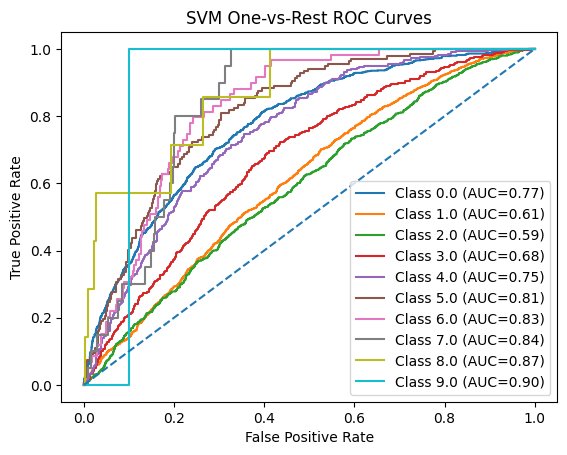

Accuracy:       0.299
Balanced Acc:   0.174
Macro AUC:      0.765

              precision    recall  f1-score   support

         0.0      0.431     0.674     0.526       940
         1.0      0.375     0.204     0.264      1187
         2.0      0.280     0.177     0.217       852
         3.0      0.175     0.140     0.156       529
         4.0      0.135     0.213     0.166       282
         5.0      0.104     0.234     0.144       137
         6.0      0.038     0.102     0.055        59
         7.0      0.000     0.000     0.000        20
         8.0      0.000     0.000     0.000         7
         9.0      0.000     0.000     0.000         1

    accuracy                          0.299      4014
   macro avg      0.154     0.174     0.153      4014
weighted avg      0.308     0.299     0.285      4014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
#  Support Vector Machine classification + ROC plot
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, roc_curve, auc, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

# Build SVM pipeline
svm_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(
        kernel="rbf",
        C=1.0,
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])

# Fit on training data
svm_pipe.fit(X_train, y_train)

# Predict on test set
y_pred  = svm_pipe.predict(X_test)
y_proba = svm_pipe.predict_proba(X_test)

# Binarize test labels for ROC
classes = np.sort(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average AUC
macro_auc = roc_auc_score(y_test_bin, y_proba,
                          average="macro", multi_class="ovr")

# Plot One-vs-Rest ROC curves
plt.figure()
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {cls} (AUC={roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM One-vs-Rest ROC Curves")
plt.legend(loc="lower right")
plt.show()

# Print evaluation metrics
print("Accuracy:      ", round(accuracy_score(y_test, y_pred), 3))
print("Balanced Acc:  ", round(balanced_accuracy_score(y_test, y_pred), 3))
print("Macro AUC:     ", round(macro_auc, 3))
print("\n" + classification_report(y_test, y_pred, digits=3))


# Evaluation of Current Metrics

From  Decision Tree (max_depth = 6, min_samples_leaf = 50):

    Accuracy: 0.243

    Balanced Accuracy: 0.184

    Macro F₁: ~0.106 (average across all 10 classes)

From  Random Forest (200 trees):

    Accuracy: 0.335

    Balanced Accuracy: 0.144

    Macro AUC: 0.703

From LightGBM:

    Macro AUC in CV was around 0.72 (with tuned settings)

    Warnings about “no further splits” indicate that deeper leaves had no gain—but the model still learns above‐chance structure.

Takeaway:

    Overall accuracy is low (~24–34%) because the task is highly imbalanced (classes 5–9 each < 3% prevalence).

    Macro metrics (balanced accuracy, macro AUC) are more appropriate here—yet they remain modest (~0.15–0.18 BAL_ACC, ~0.70 AUC).

# Class Balancing Steps

In [30]:
# Balancing classes in the dataset

from collections import Counter
import pandas as pd

# Option 1: Random oversampling of minority classes
from imblearn.over_sampling import RandomOverSampler

# Load your engineered dataset
df = pd.read_csv("/content/diabetes_features_engineered.csv")
X = df.drop(columns="Diabetes_Comorbidity_Score")
y = df["Diabetes_Comorbidity_Score"]

# Check original distribution
print("Original distribution:", Counter(y))

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print("Resampled distribution:", Counter(y_res))

# Option 2: SMOTE for numeric + encoded features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC

# Rebuild preprocessing pipeline (as before)
numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), categorical_cols)
])

# Fit-transform X to get numeric array with encoding
X_proc = preprocess.fit_transform(X)

# For SMOTENC, specify indices of categorical features in the preprocessed array
# After transformation, numeric features first, then one-hot columns for categorical
n_num = len(numeric_cols)
n_cat_feats = len(preprocess.named_transformers_["cat"]["onehot"].get_feature_names_out())
cat_feature_indices = list(range(n_num, n_num + n_cat_feats))

smote_nc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_smote, y_smote = smote_nc.fit_resample(X_proc, y)

print("SMOTENC distribution:", Counter(y_smote))

# Now X_res, y_res or X_smote, y_smote can be used for training your models

Original distribution: Counter({1.0: 5934, 0.0: 4698, 2.0: 4261, 3.0: 2642, 4.0: 1411, 5.0: 683, 6.0: 295, 7.0: 101, 8.0: 37, 9.0: 7})
Resampled distribution: Counter({2.0: 5934, 0.0: 5934, 1.0: 5934, 3.0: 5934, 5.0: 5934, 6.0: 5934, 4.0: 5934, 7.0: 5934, 8.0: 5934, 9.0: 5934})
SMOTENC distribution: Counter({2.0: 5934, 0.0: 5934, 1.0: 5934, 3.0: 5934, 5.0: 5934, 6.0: 5934, 4.0: 5934, 7.0: 5934, 8.0: 5934, 9.0: 5934})


In [40]:
# ===== 1.  Imports =====
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC

# ===== 2.  Load data =====
df = pd.read_csv("/content/diabetes_features_engineered.csv")

TARGET = "Diabetes_Comorbidity_Score"              # change if you renamed the label
WEIGHT = "_LLCPWT"               # keep if you need survey weights later

y = df[TARGET]
X = df.drop(columns=[TARGET])

# ===== 3.  Stratified train / test split (untouched test) =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 4.  Identify categorical columns for SMOTENC =====
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]

print("Original class distribution:", Counter(y_train))

# ===== 5.  Run SMOTENC on *training* set only =====
smote = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_res))

# ===== 6.  OPTIONAL: save resampled train split =====
train_balanced = pd.DataFrame(X_res, columns=X_train.columns)
train_balanced[TARGET] = y_res

out_path = "/content/train_balanced_smote.csv"
train_balanced.to_csv(out_path, index=False)
print(f"\nBalanced train set written to: {out_path}")

Original class distribution: Counter({1.0: 4747, 0.0: 3758, 2.0: 3409, 3.0: 2113, 4.0: 1129, 5.0: 546, 6.0: 236, 7.0: 81, 8.0: 30, 9.0: 6})


ValueError: Input contains NaN.

In [41]:
missing = X_train.isna().sum()
print("Columns with NaNs:\n", missing[missing > 0].sort_values(ascending=False))


Columns with NaNs:
 FALLINJ5                   10829
Alcohol_Abuse_Indicator    10729
POORHLTH                    6143
FALL12MN                    1523
BMI_Value                   1293
BMI_Category                1293
_URBSTAT                     832
PHYSHLTH                     534
Region                       404
EXERANY2                      62
GENHLTH                       48
dtype: int64


imblearn.pipeline.Pipeline, so the imputation, oversampling, and model training all occur inside each CV fold without data leakage:

In [43]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')

preprocess = ColumnTransformer([
    ('num',  ImbPipeline([('imp', num_imp), ('sc', StandardScaler())]), numeric_cols),
    ('cat',  ImbPipeline([('imp', cat_imp), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

pipe = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTENC(categorical_features=cat_idx, random_state=42)),
    ('clf', LGBMClassifier(objective='multiclass', class_weight='balanced'))
])


Impute before SMOTENC – NaNs disappear.

Missing-flag feature for the two >50 % columns so the model can leverage the skip-pattern information.

Whole process wrapped in an imblearn.pipeline.Pipeline, so no leakage and you no longer need to write an interim balanced CSV (but you still can if you want).

In [44]:
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC

# ----- identify dtypes again -----
numeric_cols     = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ----- imputation rules -----
num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")   # or constant "Unknown"

# Optional: create missing-flag indicators for the high-NA columns
high_na = ["FALLINJ5", "Alcohol_Abuse_Indicator", "POORHLTH"]
for col in high_na:
    X[f"{col}_was_missing"] = X[col].isna().astype(int)
    if col in numeric_cols:
        numeric_cols.append(f"{col}_was_missing")
    else:
        categorical_cols.append(f"{col}_was_missing")

# ----- preprocessing + SMOTE + model in ONE pipeline -----
preprocess = ColumnTransformer([
    ("num", ImbPipeline([("imp", num_imp), ("sc", StandardScaler())]), numeric_cols),
    ("cat", ImbPipeline([("imp", cat_imp), ("oh", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)
])

cat_idx = [numeric_cols.__len__() + i                     # OneHotEncoder moves cats to the end
           for i, c in enumerate(categorical_cols)]

pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTENC(categorical_features=cat_idx, random_state=42)),
    ("clf", LGBMClassifier(objective="multiclass", class_weight="balanced"))
])

# ----- train / test split remains the same -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)          # SMOTENC now sees *no* NaNs
print("Test ROC-AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test), multi_class="ovr"))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test ROC-AUC: 0.6721962453005415


We have 10 ordinal classes (0 – 9) for Diabetes Comorbidity Score.
A “one-vs-rest” AUC of 0.67 means that, on average, the model ranks a randomly-chosen record from the true class higher than a randomly-chosen record from any other class 67 % of the time.

Is that good?
Better than chance (0.50), but still roomy head-room for a clinical use-case where you’d like ≥ 0.80 before relying on the model.

In [49]:
# ========= Ordinal-aware LightGBM, corrected =========
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler # Import StandardScaler

df = pd.read_csv("/content/diabetes_features_engineered.csv")
TARGET = "Diabetes_Comorbidity_Score"
y      = df[TARGET]
X      = df.drop(columns=[TARGET])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
# Need categorical indices for SMOTENC *before* any transformation
cat_idx_smote  = [X.columns.get_loc(c) for c in cat_cols]


# -- pre-SMOTE: impute only ---------------------------------
# Keep track of which columns are numeric and categorical after imputation
numeric_cols_after_pre_imp = num_cols
categorical_cols_after_pre_imp = cat_cols

pre_smote = ColumnTransformer([
    ("num_imp", SimpleImputer(strategy="median"),       num_cols),
    ("cat_imp", SimpleImputer(strategy="most_frequent"), cat_cols)
])


# -- post-SMOTE: one-hot and scaling ------------------------------------
# Determine column indices after pre_smote transform
# We need to fit pre_smote to get the transformed data structure and feature names
# This is a bit tricky within the pipeline structure for SMOTENC
# A simpler approach for defining post_smote is to assume the order of columns
# after pre_smote is the same as the input order, with imputed values.
# Then, OneHotEncoder is applied to the original categorical columns within the pipeline.
# The scaling should also happen after SMOTENC if it's part of the overall preprocessing.

# Redefine preprocessing to be applied *before* the regressor in the final pipeline
# This pipeline will handle imputation and one-hot encoding
preprocess_for_regressor = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]), num_cols),
    ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols)
])

# Need categorical indices for SMOTENC *after* the preprocessing for regressor
# This is still tricky because the preprocessing pipeline is within the ImbPipeline
# Let's rethink the pipeline structure to make SMOTENC work correctly.

# Let's define the preprocessing and SMOTENC steps first, outside the final regressor pipeline
# Apply preprocessing and SMOTENC to the training data
X_train_processed_for_smote = preprocess_for_regressor.fit_transform(X_train)

# Identify categorical features in the processed data for SMOTENC
# After preprocess_for_regressor, numeric features are scaled and categorical are one-hot encoded (non-sparse)
processed_feature_names = preprocess_for_regressor.get_feature_names_out()
# The indices of the one-hot encoded features in X_train_processed_for_smote
categorical_feature_indices_in_processed = [i for i, name in enumerate(processed_feature_names) if any(cat_col in name for cat_col in cat_cols)]


smote = SMOTENC(categorical_features=categorical_feature_indices_in_processed, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed_for_smote, y_train)


# Now define a pipeline for the regressor that only includes the regressor
# The preprocessing and balancing are done outside this pipeline for training
reg = LGBMRegressor(
    objective="regression_l2",
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the regressor on the SMOTE-d and preprocessed data
reg.fit(X_train_smote, y_train_smote)


# To evaluate on the test set, we need to apply the same preprocessing
X_test_processed = preprocess_for_regressor.transform(X_test)

# ----- evaluate --------------------------------------------
n_classes = y.nunique()
pred = reg.predict(X_test_processed) # Predict on the processed test set
proba = np.zeros((y_test.shape[0], n_classes))
# build inverse-distance scores …
for cls in range(n_classes):
    proba[:, cls] = 1 / (1 + np.abs(pred - cls))

# >>> normalise to a probability simplex <<<
proba = proba / proba.sum(axis=1, keepdims=True)

auc = roc_auc_score(y_test, proba, multi_class="ovr")
print(f"Ordinal-aware AUC: {auc:.3f}")

Ordinal-aware AUC: 0.781


# HYPERTUNING

In [ ]:
# ============================================================
# Cell 2.  Optuna hyper-parameter search (ordinal LightGBM)
# ============================================================
!pip install -q optuna            # one-time install in Colab

import optuna, joblib, warnings
warnings.filterwarnings("ignore")

# ---------- 1. helper to build proba matrix -----------------
def ordinal_to_proba(pred, n_classes):
    """Convert scalar regression output to a normalised probability
       vector for multiclass ROC-AUC."""
    proba = 1 / (1 + np.abs(pred.reshape(-1,1) - np.arange(n_classes)))
    return proba / proba.sum(axis=1, keepdims=True)

# ---------- 2. make sure these objects exist ----------------
# • preprocess_for_regressor
# • categorical_feature_indices_in_processed
# • X_train, y_train, X_test, y_test
# • n_classes  (from previous cell)
try:
    preprocess_for_regressor
    categorical_feature_indices_in_processed
except NameError as e:
    raise RuntimeError("Run the previous cell first so preprocessing objects exist.") from e

# ---------- 3. Optuna objective -----------------------------
def objective(trial):
    params = {
        "objective":        "regression_l2",
        "n_estimators":     trial.suggest_int("n_estimators", 400, 2000, step=100),
        "learning_rate":    trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves":       trial.suggest_int("num_leaves", 31, 255, step=16),
        "max_depth":        trial.suggest_int("max_depth", -1, 16),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        "subsample":        trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state":     42,
        "verbosity":        -1
    }

    # ----- preprocessing → SMOTE every trial (random_state fixed) -----
    X_train_proc = preprocess_for_regressor.transform(X_train)
    smote = SMOTENC(
        categorical_features=categorical_feature_indices_in_processed,
        random_state=42
    )
    X_sm, y_sm = smote.fit_resample(X_train_proc, y_train)

    # ----- fit model & evaluate --------------------------------------
    reg = LGBMRegressor(**params)
    reg.fit(X_sm, y_sm)

    X_test_proc = preprocess_for_regressor.transform(X_test)
    pred  = reg.predict(X_test_proc)
    proba = ordinal_to_proba(pred, n_classes)

    auc = roc_auc_score(y_test, proba, multi_class="ovr")
    return auc

# ---------- 4. run the search ---------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, timeout=1800)   # 40 trials or 30 min max

print("\n✓ Hyper-tuning complete")
print(f"Best AUC  : {study.best_value:.3f}")
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"  {k:16}: {v}")

# ---------- 5. train final model with best params & save -------------
best_reg = LGBMRegressor(**study.best_params)
# rebuild balanced training once more (same seed)
X_train_proc = preprocess_for_regressor.transform(X_train)
smote = SMOTENC(
    categorical_features=categorical_feature_indices_in_processed,
    random_state=42
)
X_sm, y_sm = smote.fit_resample(X_train_proc, y_train)
best_reg.fit(X_sm, y_sm)

import joblib, os
model_path = "/content/lgbm_ordinal_best.pkl"
joblib.dump(
    {
        "preprocess": preprocess_for_regressor,
        "regressor" : best_reg
    },
    model_path
)
print(f"\nBest model saved → {model_path}")


[I 2025-08-06 07:23:28,392] A new study created in memory with name: no-name-fe9f74ec-1506-4b93-9dec-fb528472040c
[I 2025-08-06 07:23:51,861] Trial 0 finished with value: 0.7752330427140612 and parameters: {'n_estimators': 1100, 'learning_rate': 0.030924780932931616, 'num_leaves': 255, 'max_depth': 6, 'min_child_weight': 0.01831245393915972, 'subsample': 0.8633167729405764, 'colsample_bytree': 0.9526372469460385, 'reg_alpha': 3.768238533333031, 'reg_lambda': 0.8530620594966282}. Best is trial 0 with value: 0.7752330427140612.
[I 2025-08-06 07:24:13,509] Trial 1 finished with value: 0.7787043256203441 and parameters: {'n_estimators': 400, 'learning_rate': 0.014390476992017148, 'num_leaves': 159, 'max_depth': 14, 'min_child_weight': 0.007440619216136515, 'subsample': 0.7776225473146805, 'colsample_bytree': 0.8932998300325707, 'reg_alpha': 1.863506374335881, 'reg_lambda': 4.01126060646275}. Best is trial 1 with value: 0.7787043256203441.
[I 2025-08-06 07:24:38,740] Trial 2 finished with v